### Calculate median

In [1]:
import random
import numpy as np
import pandas as pd


import torch.multiprocessing as mp
mp.set_start_method('spawn')

import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable, grad


import matplotlib.pyplot as plt
%matplotlib inline

import h5py
from power_spectrum_utils import power_spectrum_np
from wgan_utils import define_test, check_coords


from sklearn.preprocessing import StandardScaler, MinMaxScaler

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:

mean_5=14280.155
std_5=89914.586
max_5=47676240

In [3]:
def get_samples(file, s_sample, nsamples, test_coords):
    #n is size of minibatch, get valid samples (not intersecting with test_coords)
    sample_list=[]
    m=2048-s_sample
    for n in range(nsamples):
        #print("Sample No = " + str(n + 1) + " / " + str(nsamples))
        sample_valid=False
        while sample_valid==False:
            x = random.randint(0,m)
            y = random.randint(0,m)
            z = random.randint(0,m)
            sample_coords = {'x':[x,x+s_sample], 
                             'y':[y,y+s_sample], 
                             'z':[z,z+s_sample]}
            
            sample_valid = check_coords(test_coords, sample_coords)
        
        sample_list.append(sample_coords)
    
    #Load cube and get samples and convert them to np.arrays
    sample_array=[]
    #f file has to be opened outisde the function
    for c in sample_list:
        a = f[c['x'][0]:c['x'][1],
              c['y'][0]:c['y'][1],
              c['z'][0]:c['z'][1]]
        
        sample_array.append(np.array(a))
    
    return np.array(sample_array)

In [7]:
redshift='4.0'
random.seed(1)
tc=define_test(10, 64)

s_sample = 64
datapath='../../../../../'
#mean_, nonz, std_,max_=[],[],[],[]

f = h5py.File(datapath+'fields_z='+redshift+'.hdf5', 'r')
f=f['delta_HI']

In [5]:
def build_df(n_samples):
    col_list = ['mean', 'std', 'median', 'max', 'pk_mean', 'pk_std', 'pk_range', 'below_mean']
    df = pd.DataFrame(index=list(range(n_samples)), 
                       columns=col_list)
    
    arr=get_samples(0, s_sample, n_samples, tc)
    
    no_pixels = len(arr[0].flatten())
    
    for n in range(arr.shape[0]):

        k, Pk = power_spectrum_np(arr[n], mean_5, s_sample)
        
        row = {'mean': arr[n].mean(), 'std': arr[n].std(), 'median': np.median(arr[n]) , 'max': np.amax(arr[n]), 
               'pk_mean': Pk.mean(), 'pk_std': Pk.std()  , 'pk_range': Pk[0]-Pk[-1] ,
               'below_mean' : (arr[n]< mean_5).sum() / no_pixels }
               #'above_std' : 1 - ((arr [n]< 3*std_5 ).sum()) / no_pixels }
        df.loc[n] = row
    
    #Standardize
    scaler = MinMaxScaler() #StandardScaler()
    scaler.fit(df)
    df = scaler.transform(df)
    
    return pd.DataFrame(df, columns=col_list)

In [8]:
data= build_df(50)
data.to_csv('GMM_df_1000')
data

,mean,std,median,max,pk_mean,pk_std,pk_range,below_mean
0,0.015784,0.019888,0.324459,0.010579,0.000256,1.694893e-04,1.739712e-04,0.919791
1,0.034472,0.038055,0.356649,0.025988,0.001062,7.741828e-04,7.520842e-04,0.885445
2,0.000384,0.002231,0.000000,0.003030,0.000006,2.012285e-06,1.727107e-06,1.000000
3,0.025052,0.034716,0.505976,0.040490,0.000547,2.132288e-04,1.948834e-04,0.872670
4,0.012087,0.025185,0.149735,0.031262,0.000413,2.500044e-04,1.927663e-04,0.963560
5,0.056278,0.054939,0.471836,0.030855,0.001862,1.231192e-03,1.096591e-03,0.810681
6,0.030733,0.037713,0.414080,0.043759,0.000861,5.196640e-04,4.001422e-04,0.873717
7,0.041197,0.048011,0.366596,0.041780,0.001501,1.034309e-03,9.864446e-04,0.847539
8,0.150091,0.109501,0.672275,0.064525,0.008657,6.516685e-03,6.106712e-03,0.567958
9,0.041394,0.033752,0.363643,0.018155,0.000765,7.585379e-04,8.776146e-04,0.803351


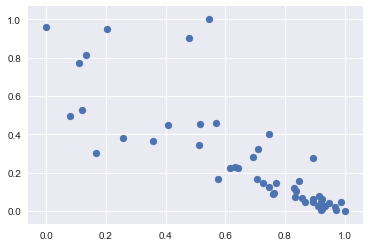

In [26]:
plt.scatter(data['below_mean'], data['std'])

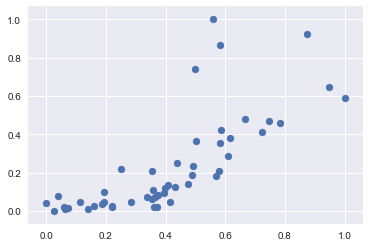

In [25]:
plt.scatter(data['median'], data['mean'])

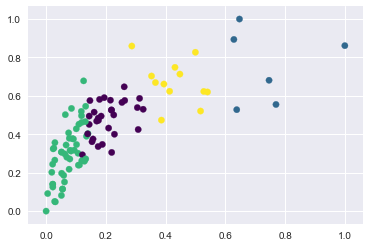

In [15]:
#https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html
from sklearn.mixture import GaussianMixture as GM
import seaborn as sns; sns.set()

gmm = GM(n_components=4).fit(data)
labels = gmm.predict(data)
probs = gmm.predict_proba(data)

data=np.array(data)


plt.scatter(data[:, 1], data[:, 2], c=labels, s=40, cmap='viridis');